<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/7_AdvancedConcepts/AdvancedConcepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Concepts

**Objective** : To achieve 87% accuracy with total Params less than 100k in CIFAR dataset and
 
1.  To use GPU ✓
2.  To use architecture C1C2C3C40 (No MaxPooling, but 3 3x3 layers with stride of 2 instead) 
3.   To use Dilated kernels here instead of MP or strided convolution
4.   To achieve total Receptive Field more than 52
5.   To use Depthwise Separable Convolution at least in 2 of the layers
6.   To use Dilated Convolution at least in one of the layers
7.   To use GAP (compulsory mapped to # of classes):- CANNOT add FC after GAP to target #of classes
8.   To use correct Normalization values by having computing mean and std value in Transform ✓
9.   To use albumentation library and apply:
> *   horizontal flip
> *   shiftScaleRotate 
> *   coarseDropout (max_holes = 1, max_height=16px, max_width=1, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
> *   grayscale



In [24]:
%matplotlib inline
import albumentations as A


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [27]:
print(trainset.data.mean(axis=(0,1,2))/255)
print(trainset.data.std(axis=(0,1,2))/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship   car   cat   car


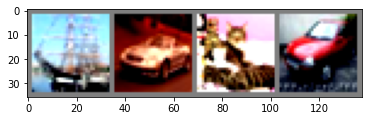

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [46]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1, bias = False),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.03),

            nn.Conv2d(16, 16, 3, padding=1, bias = False), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.03),

            nn.Conv2d(16, 32, 3,  padding=1, bias = False), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.03),
        
        )

        self.trans1 = nn.Sequential(
            nn.Conv2d(32, 16, 1, stride=2), # 22x22 output - 11x11 RF 14x14
            nn.ReLU(),
        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(16, 16, 3,  padding=1, bias = False), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.03),

            nn.Conv2d(16, 32, 3,  padding=1, bias = False),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.03),
            
        )

        self.trans2 = nn.Sequential(

            nn.Conv2d(32, 16, 1, stride=2), # 9x9 output - 7x7 RF 18x18
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,  padding=1, bias = False), # 7x7 output - 5x5 RF 20x20
            nn.Conv2d(16, 10, 1)
        )

        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)




In [47]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
         Dropout2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
         Dropout2d-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,608
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
        Dropout2d-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 16, 16, 16]             528
             ReLU-14           [-1, 16,

In [48]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)

cuda


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [50]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.086
[1,  4000] loss: 1.897
[1,  6000] loss: 1.799
[1,  8000] loss: 1.721
[1, 10000] loss: 1.653
[1, 12000] loss: 1.598
[2,  2000] loss: 1.524
[2,  4000] loss: 1.514
[2,  6000] loss: 1.480
[2,  8000] loss: 1.447
[2, 10000] loss: 1.434
[2, 12000] loss: 1.404
Finished Training


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


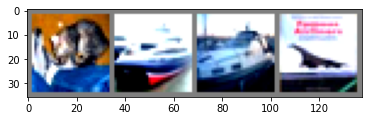

In [51]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [52]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [53]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [54]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 67 %
Accuracy of  bird : 22 %
Accuracy of   cat : 31 %
Accuracy of  deer : 36 %
Accuracy of   dog : 59 %
Accuracy of  frog : 50 %
Accuracy of horse : 52 %
Accuracy of  ship : 68 %
Accuracy of truck : 66 %
